*********************************
# Features and Plots
*********************************

In [1]:
import cait as ai
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ['svg']  # we need this for a suitable resolution of the plots

In [2]:
path_data = 'test_data/'
fname = 'test_001'
channels_rdt = [0,1]
channels_h5 = [0,1]

In [3]:
dh = ai.DataHandler(channels=channels_rdt)
dh.set_filepath(path_h5=path_data,
                fname=fname,
                appendix=False)  # this specifies, that the file does not have a "-P_Ch0..." appendix

DataHandler Instance created.


## Noise Power Spectrum

Calculate NPS.


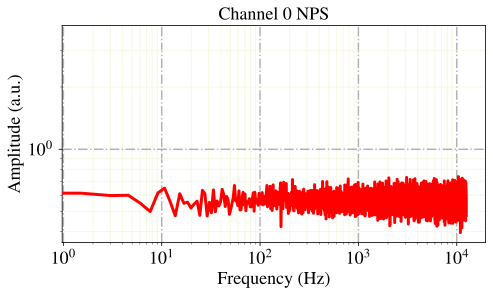

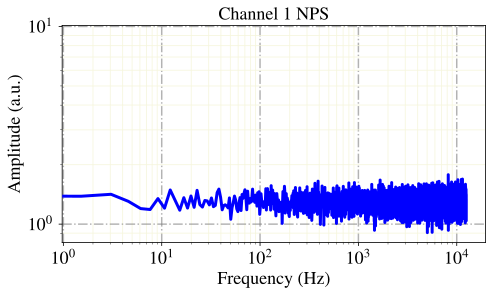

In [4]:
dh.calc_nps(percentile=95)
for c in channels_h5:
    dh.show_nps(channel=c, dpi=150, title='Channel {} NPS'.format(c))

## Event Classes

In [5]:
ph = dh.get('events', 'mainpar')[0,:,0]
ph_light = dh.get('events', 'mainpar')[1,:,0]
decay_time = (dh.get('events','mainpar')[0,:,6] - dh.get('events','mainpar')[0,:,4])/dh.sample_frequency

In [6]:
absorbers = ai.cuts.LogicalCut(initial_condition=decay_time > 0.004)
carriers = ai.cuts.LogicalCut(absorbers.get_antiflag())

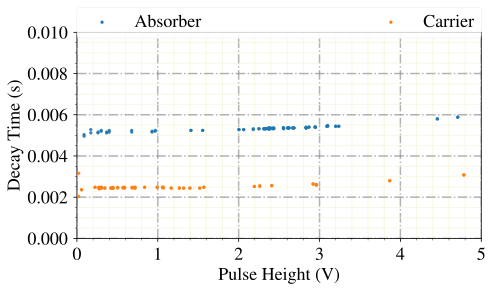

In [7]:
plt.close()
ai.styles.use_cait_style(dpi=150)
plt.scatter(ph[absorbers.get_flag()], decay_time[absorbers.get_flag()], marker='.', alpha=0.9, zorder=10, label='Absorber')
plt.scatter(ph[carriers.get_flag()], decay_time[carriers.get_flag()], marker='.', alpha=0.9, zorder=10, label='Carrier')
ai.styles.make_grid()
plt.xlabel('Pulse Height (V)')
plt.ylabel('Decay Time (s)')
plt.xlim([0,5])
plt.ylim([0,0.01])
legend = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), mode="expand", borderaxespad=0., ncol=3)
for lh in legend.legendHandles:
    lh.set_alpha(1.0)
plt.show()

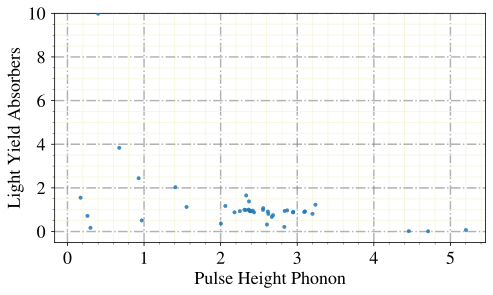

LY Plot created.


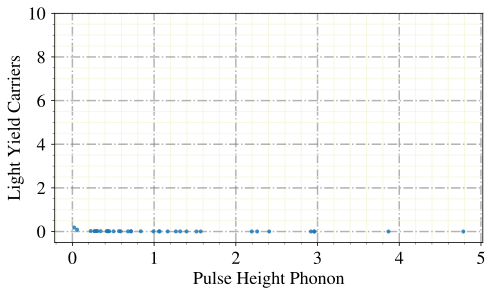

LY Plot created.


In [8]:
dh.show_ly(xlabel='Pulse Height Phonon', ylabel='Light Yield Absorbers', ylim=(-0.5,10), s=50, alpha=0.6, 
          only_idx=absorbers.get_flag())
dh.show_ly(xlabel='Pulse Height Phonon', ylabel='Light Yield Carriers', ylim=(-0.5,10), s=50, alpha=0.6, 
          only_idx=carriers.get_flag())

## Standard Event

88 Events handed.
14 left after PH cut.
14 Events used to generate Standardevent.
Parameter:  [-1.11782398  3.4389503   0.56193181  4.78760781  1.66480365  1.04291462]
88 Events handed.
12 left after PH cut.
12 Events used to generate Standardevent.
Parameter:  [ 0.683519    2.37969942  0.78260471 29.13184047  3.58849651  2.02040077]
events SEV calculated.


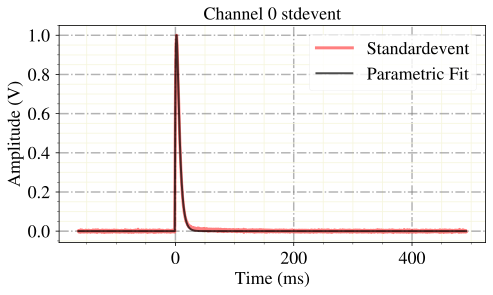

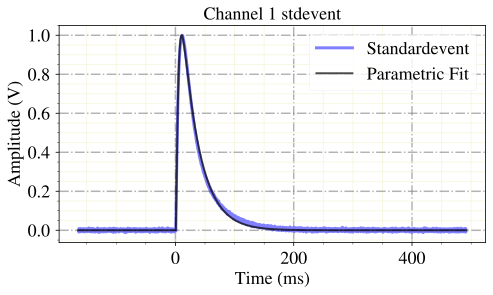

In [9]:
dh.calc_sev(pulse_height_interval=[[0.3, 1.5], [0.3, 1.5]],
            left_right_cutoff=None,
            rise_time_interval=None,
            decay_time_interval=None,
            onset_interval=None,
            t0_start=None,
            opt_start=False,
            use_idx=absorbers.get_idx())
for c in channels_h5:
    dh.show_sev(channel=c, dpi=150)

In [10]:
down=4
dh.apply_sev_fit(down=4, name_appendix='_down{}'.format(down), processes=4,
                 truncation_level=[2, 1.5], events_to_fit=160, verb=True)

Calculating SEV Fit.
Fitting channel 0.


100%|██████████| 160/160 [00:18<00:00,  8.57it/s]


Fitting channel 1.


100%|██████████| 160/160 [00:18<00:00,  8.69it/s]


Done.


In [11]:
ph_fitted = dh.get('events', 'sev_fit_par_down{}'.format(down))[0,:,0]
fit_rms = dh.get('events', 'sev_fit_rms_down{}'.format(down))[0]

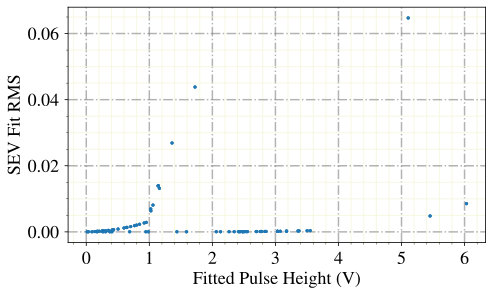

In [12]:
dh.show_scatter(groups=['events', 'events'],
                keys=['sev_fit_par_down{}'.format(down), 'sev_fit_rms_down{}'.format(down)],
                title=None,
                idx0s=[0, 0],  # 0 is the phonon channel
                idx2s=[0, None],
                xlabel='Fitted Pulse Height (V)',
                ylabel='SEV Fit RMS',
                marker='.',
                )

72 Events handed.
72 left after PH cut.
72 Events used to generate Standardevent.
Parameter:  [ -2.48283735   7.02063006   6.92453444 125.46328689   0.93441572
   1.34356122]
events SEV calculated.


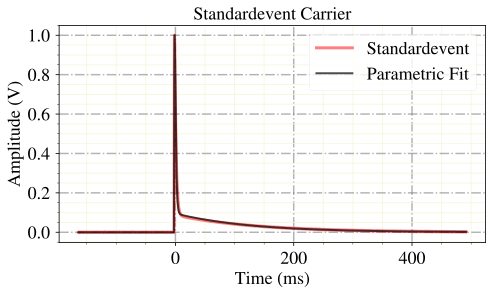

In [13]:
dh.calc_exceptional_sev(naming='carrier',
                        channel=0,  # it is in the phonon channel
                        use_idx=carriers.get_idx())
dh.show_exceptional_sev(naming='carrier', dpi=150, title='Standardevent Carrier')

## Optimum Filter

CREATE OPTIMUM FILTER.
OF updated.


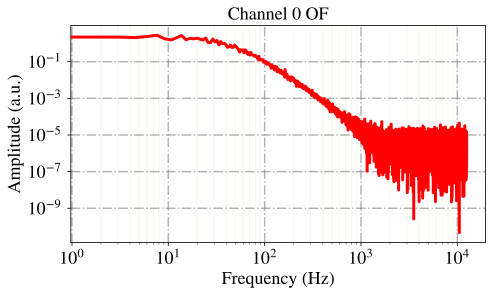

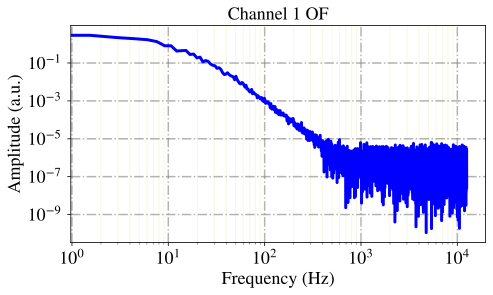

In [14]:
dh.calc_of()
for c in channels_h5:
    dh.show_of(channel=c, dpi=150)

CREATE OPTIMUM FILTER.
OF updated.


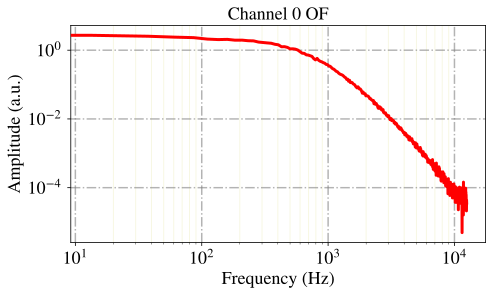

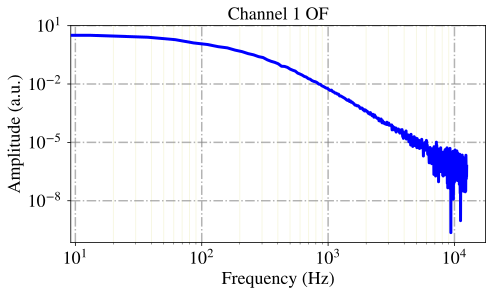

In [15]:
dh.calc_of(down=16)
for c in channels_h5:
    dh.show_of(down=16, channel=c, dpi=150)

In [16]:
dh.apply_of()

Calculating OF Heights.


## Main Parameters

In [17]:
dh.calc_mp()

CALCULATE MAIN PARAMETERS.


In [18]:
dh.calc_additional_mp()

CALCULATE ADDITIONAL MAIN PARAMETERS.


## Spectrum

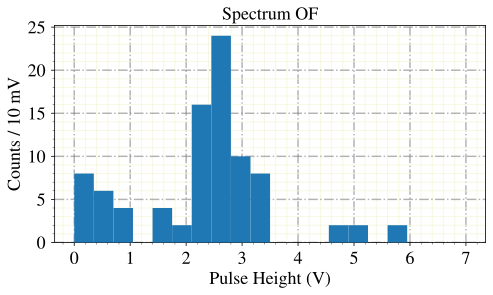

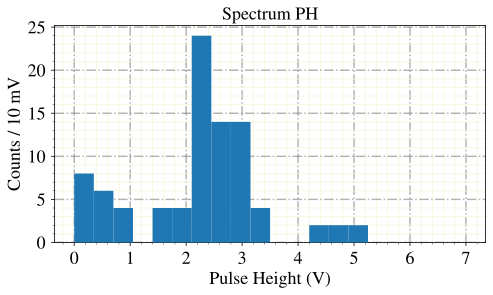

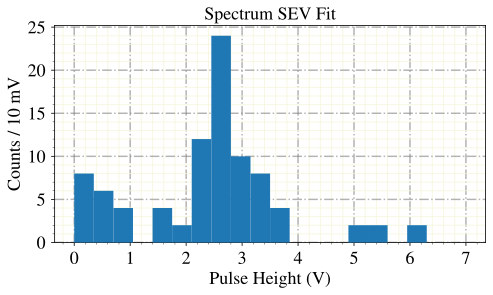

In [19]:
channel=0

dh.show_values(group='events', key='of_ph', bins=20, idx0=channel, cut_flag=absorbers.get_flag(), range=(0,7),
               xlabel='Pulse Height (V)', ylabel='Counts / 10 mV', title='Spectrum OF')
dh.show_values(group='events', key='mainpar', bins=20, idx0=channel, idx2=0, cut_flag=absorbers.get_flag(), range=(0,7),
               xlabel='Pulse Height (V)', ylabel='Counts / 10 mV', title='Spectrum PH')
dh.show_values(group='events', key='sev_fit_par_down{}'.format(4), bins=20, idx0=channel, idx2=0, cut_flag=absorbers.get_flag(), range=(0,7),
               xlabel='Pulse Height (V)', ylabel='Counts / 10 mV', title='Spectrum SEV Fit')

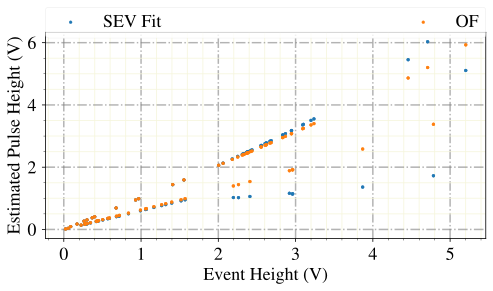

In [20]:
ph = dh.get('events', 'mainpar')[0,:,0]
ph_fitted = dh.get('events', 'sev_fit_par_down{}'.format(4))[0,:,0]
ph_filter = dh.get('events', 'of_ph')[0]

plt.close()
ai.styles.use_cait_style(dpi=150)
plt.scatter(ph, ph_fitted, marker='.', alpha=0.9, zorder=10, label='SEV Fit')
plt.scatter(ph, ph_filter, marker='.', alpha=0.9, zorder=10, label='OF')
ai.styles.make_grid()
plt.xlabel('Event Height (V)')
plt.ylabel('Estimated Pulse Height (V)')
#plt.xlim([0,5])
#plt.ylim([0,0.01])
legend = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), mode="expand", borderaxespad=0., ncol=3)
for lh in legend.legendHandles:
    lh.set_alpha(1.0)
plt.show()

## PCA

In [21]:
dh.apply_pca(nmbr_components=2, down=2)

Channel  0
Explained Variance:  [0.83212278 0.16413372]
Singular Values:  [144.65223892  64.24367312]
Channel  1
Explained Variance:  [0.9742551  0.02509298]
Singular Values:  [333.98913486  53.60090451]


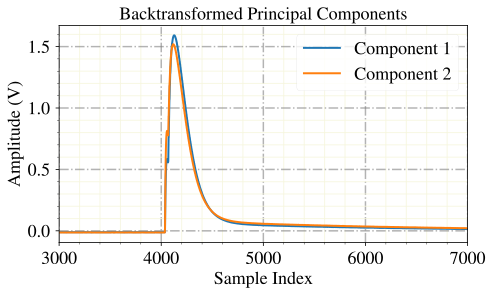

In [22]:
components = dh.get('events', 'pca_components')

plt.close()
ai.styles.use_cait_style(dpi=150)
for i, comp in enumerate(components[0]):
    plt.plot(comp, label='Component {}'.format(i+1))
plt.title('Backtransformed Principal Components')
ai.styles.make_grid()
plt.xlabel('Sample Index')
plt.ylabel('Amplitude (V)')
plt.xlim(3000, 7000)
plt.legend()
plt.show()

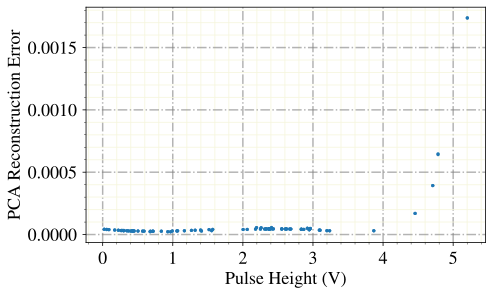

In [23]:
dh.show_scatter(groups=['events', 'events'],
                keys=['mainpar', 'pca_error'],
                title=None,
                idx0s=[0, 0],  # 0 is the phonon channel
                idx2s=[0, None],
                xlabel='Pulse Height (V)',
                ylabel='PCA Reconstruction Error',
                marker='.',
                )

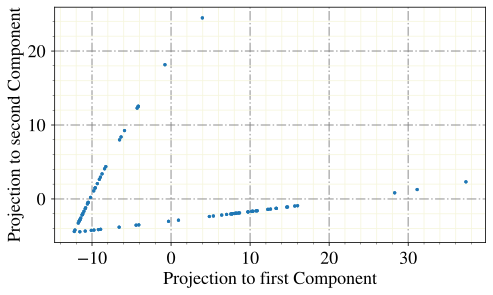

In [24]:
dh.show_scatter(groups=['events', 'events'],
                keys=['pca_projection', 'pca_projection'],
                title=None,
                idx0s=[0, 0],  # 0 is the phonon channel
                idx2s=[0, 1],
                xlabel='Projection to first Component',
                ylabel='Projection to second Component',
                marker='.',
                )

## Baseline Cleaning

In [25]:
dh.calc_bl_coefficients(down=4)

Calculating Baseline Coefficients.
Fit Coeff and Rms calculated.


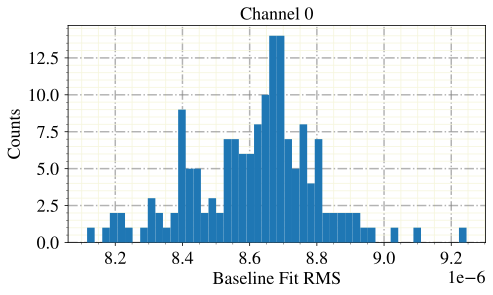

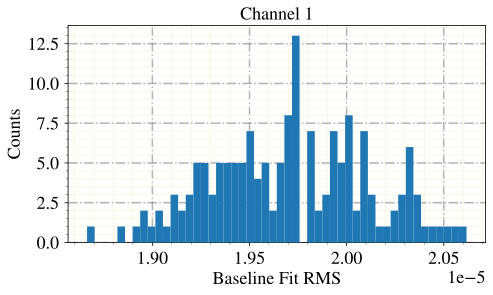

In [26]:
for c in [0,1]:
    dh.show_values(group='noise', key='fit_rms', bins=50, idx0=c, range=None,
                   xlabel='Baseline Fit RMS', ylabel='Counts', title='Channel {}'.format(c))